# Main Notebook

## Global Variables

In [31]:
%load_ext autoreload
%autoreload 2
from p_pack import globals as g
# The total number of optimization steps to perform during training.
g.num_steps: int = 10
#training rate
g.training_rate : float =  0.1
# The frequency at which data is re-uploaded into the circuit. A new data layer is introduced every `reupload_freq` layers.
g.reupload_freq: int = 2
# The number of modes in the photonic circuit.
g.num_modes_circ: int = 10
# The number of layers in the photonic circuit.
g.depth: int = 10
# The user only needs to modify this FEATURE_SIZE.
g.num_features = 5
# probability of sucess for each mode
g.p_suc_inputs = 1
#intended photon input array - 'full' for all modes, 'n' for n modes, for specify list of positions
g.input_positions= [0] #'full' for all modes, 'n' for n modes, for specify list of POSITIONS
#Aim for number of photons
g.aim = 1
# 0 to not discard, 1 to discard 
g.discard = 0
# Comparison operator used when deciding whether to discard
# training updates based on the number of photons measured.
# Possible values: '!=', '<', '<=', '>', '>=', '=='
g.discard_condition = '!=' 
# Optional range for photon counts when using discard_condition='range'.
# Should be a tuple (min_value, max_value). Set to None to disable.
g.discard_range = None
#switch for the trainable small photon loss scale, 0 - for no scaling, 1 - for scaling
g.loss_function = 0
# If set to a float value, all phases are initialised to this
# constant instead of random values.  ``None`` keeps the random
# initialisation behaviour.
g.phase_init_value: float = 0.1
# Batch processing configuration
# 'full'  : use entire dataset each update
# 'mini'  : use mini-batches of size ``mini_batch_size``
# 'single': process one sample at a time
g.batch_mode: str = 'full'
g.mini_batch_size: int = 1000
g.master_key = g.jax.random.PRNGKey(2)
g.max_photons = 3
g.input_config = g.input_config_maker(g.input_positions, g.num_modes_circ, g.p_suc_inputs)
print(g.input_config)
from p_pack import pre_p, circ, model, loss, optimiser, train, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
((1, 0, 0, 0, 0, 0, 0, 0, 0, 0), (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))


## Load Data

In [32]:

train_set, train_labels, test_set, test_labels = g.final_load_data(g.num_features)

## Training Loss - Single Depth

[save_run] Saved outputs → dump/p0.npz
[save_run] Saved globals → dump/p0g
[save_run] Appended entry to data_log
Training with, num_features:  5 , num_steps:  10 , took  0.3219738205273946  minutes


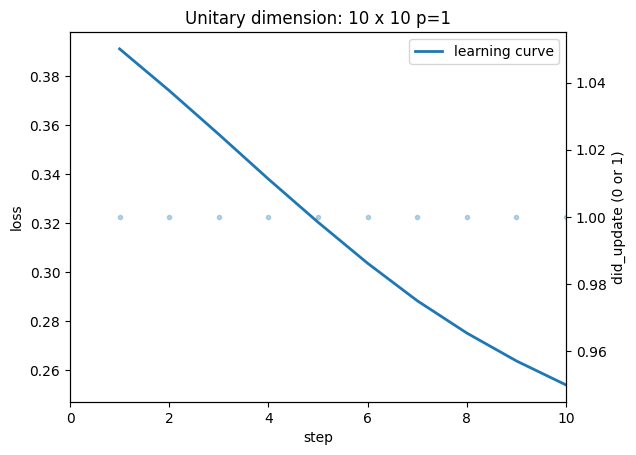

In [33]:
# Initialize the phases
init_phases = circ.initialize_phases(g.depth, 2*g.num_features, )  
weights_data = g.jnp.ones(shape = [init_phases.shape[0],init_phases.shape[1]])
# Initialize the carry for Adam.
# init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data, master_key)
photon_loss_scale = float(1)
# compute the very first loss:
initial_loss, (n0, key) = loss.loss(init_phases, train_set, train_labels, weights_data, photon_loss_scale, g.input_config, g.master_key, g.loss_function, g.aim, g.reupload_freq)
init_carry = (init_phases, train_set, train_labels, weights_data, photon_loss_scale,
                                                  0.0*init_phases, 0.0*init_phases,
                                                  0.0*weights_data, 0.0*weights_data,
                                                  0.0*photon_loss_scale, 0.0*photon_loss_scale, 
                                                  key, initial_loss)


log_file = 'data_log'
folder = 'dump'
test_name = 'p0'
global_name = 'p0g'


# Run the training, and output  time taken. 
b = g.time.time()
#carry, loss_mem, update_mem, photon_mem = g.jax.block_until_ready(train.train(init_carry))
carry, loss_mem, update_mem, photon_mem = utils.save_run(log_file, folder, test_name, global_name, init_carry)
e = g.time.time()
print('Training with, num_features: ', g.num_features, 
      ', num_steps: ', g.num_steps,
        ', took ', (e-b)/60, ' minutes')

# Loss Before/After on train set + Loss on test set
trained_phases, trained_weights = carry[0], carry[3]
steps  = g.np.array(loss_mem[:, 0], dtype=int)
losses = g.np.array(loss_mem[:, 1], dtype=float)
updates = g.np.array(update_mem, dtype=int)
#init_loss = loss.loss(init_phases, train_set, train_labels, weights_data, 1, g.input_config, g.master_key, g.loss_function, g.aim)
#train_loss = loss.loss(trained_phases, train_set, train_labels, trained_weights, photon_loss_scale, g.input_config, g.master_key, g.loss_function, g.aim)
#test_loss = loss.loss(trained_phases, test_set, test_labels, trained_weights, photon_loss_scale, g.input_config, g.master_key, g.loss_function, g.aim)
#print(init_loss, train_loss, test_loss)
# plotting the learning curve
fig, ax1 = g.plt.subplots()
ax1.plot(g.np.array(loss_mem[:,0]), g.np.array(loss_mem[:,1]), linewidth=2, label=r"learning curve" )
ax1.set(xlim = (0,g.num_steps), xlabel="step", ylabel = "loss",)
ax2 = ax1.twinx()
ax2.plot(steps, updates, 'o', alpha=0.3, markersize=3, label="did_update")
ax2.set_ylabel("did_update (0 or 1)")
# ax.axhline(init_loss, color='r', linestyle='--', label=f"Init train loss = {init_loss:.4f}")
# ax.axhline(train_loss, color='g', linestyle='--', label=f"Final train loss = {train_loss:.4f}")
# ax.axhline(test_loss, color='b', linestyle='--', label=f"Test loss = {test_loss:.4f}")
unitary_shape = trained_phases.shape  
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")
ax1.set_title(f"Unitary dimension: {2*unitary_shape[1]} x {2*unitary_shape[1]} p={g.p_suc_inputs}")
ax1.legend()
g.plt.show()

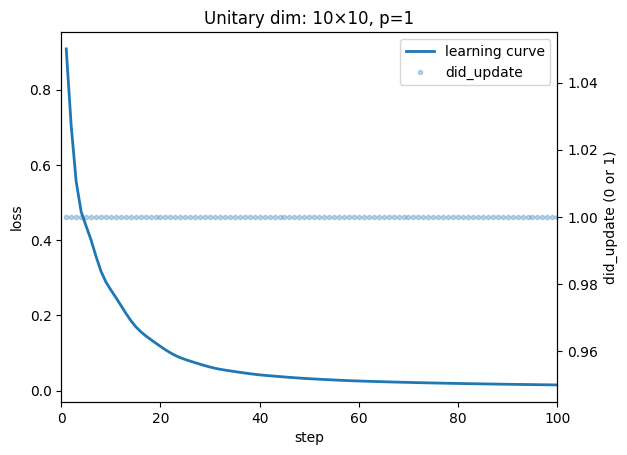

In [36]:
data_folder = "p-suc-vary-p1-d0"
data_name   = "p1.npz"
globals_name = "p1g.npz"

# 1) load outputs
out = g.np.load(g.os.path.join(data_folder, data_name))
loss_mem   = out["loss_mem"]
update_mem = out["update_mem"]

# 2) extract
steps   = loss_mem[:, 0].astype(int)
losses  = loss_mem[:, 1].astype(float)
updates = update_mem.astype(int)

# 3) pull plot params from your globals file (optional)
gl = g.np.load(g.os.path.join(data_folder, globals_name))
num_steps     = int(gl["num_steps"])      # if you saved it
p_suc_inputs  = gl["p_suc_inputs"].item() # same

# 4) plot
fig, ax1 = g.plt.subplots()
ax1.plot(steps, losses, linewidth=2, label="learning curve")
ax1.set(xlim=(0, num_steps), xlabel="step", ylabel="loss")

ax2 = ax1.twinx()
ax2.plot(steps, updates, "o", alpha=0.3, markersize=3, label="did_update")
ax2.set_ylabel("did_update (0 or 1)")

# merge legends
l1, lbls1 = ax1.get_legend_handles_labels()
l2, lbls2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lbls1 + lbls2, loc="upper right")

unitary_shape = out["carry_0"].shape  # carry_0 was your trained_phases
ax1.set_title(f"Unitary dim: {2*unitary_shape[1]}×{2*unitary_shape[1]}, p={p_suc_inputs}")
g.plt.show()

In [30]:
log_file = 'data_log'
folder = 'new2-reup-fix'
# p_suc_list = [0, 1, 2, 3, 4, 5, 6 , 7, 8]
p_suc_list = [0, 1, 2]
global_var = g.reupload_freq
file_indent = 'f'

def data_prod_iterator(variable_list, globals_v, log_file, folder, file_indent):
    for var in variable_list:
        test_name    = f"{file_indent}{var}.npz"
        global_name = f"{file_indent}{var}g.npz"
        

        globals_v = var
        g.input_config = g.input_config_maker(g.input_positions, g.num_modes_circ, g.p_suc_inputs)
        

        #  Initialize the phases
        init_phases = circ.initialize_phases(g.depth, 2*g.num_features, )  
        weights_data = g.jnp.ones(shape = [init_phases.shape[0],init_phases.shape[1]])
        # Initialize the carry for Adam.
        # init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data, master_key)
        photon_loss_scale = float(1)
        # compute the very first loss:
        initial_loss, (n0, key) = loss.loss(init_phases, train_set, train_labels, weights_data, photon_loss_scale, g.input_config, g.master_key, g.loss_function, g.aim, g.reupload_freq)
        init_carry = (init_phases, train_set, train_labels, weights_data, photon_loss_scale,
                                                        0.0*init_phases, 0.0*init_phases,
                                                        0.0*weights_data, 0.0*weights_data,
                                                        0.0*photon_loss_scale, 0.0*photon_loss_scale, 
                                                        key, initial_loss)

        carry, loss_mem, update_mem, photon_mem = utils.save_run(log_file, folder, test_name, global_name, init_carry)
        print(var, " done")

data_prod_iterator(p_suc_list, global_var, log_file, folder, file_indent)

[save_run] Saved outputs → new2-reup-fix/f0.npz
[save_run] Saved globals → new2-reup-fix/f0g.npz
[save_run] Appended entry to data_log
0  done
[save_run] Saved outputs → new2-reup-fix/f1.npz
[save_run] Saved globals → new2-reup-fix/f1g.npz
[save_run] Appended entry to data_log
1  done
[save_run] Saved outputs → new2-reup-fix/f2.npz
[save_run] Saved globals → new2-reup-fix/f2g.npz
[save_run] Appended entry to data_log
2  done


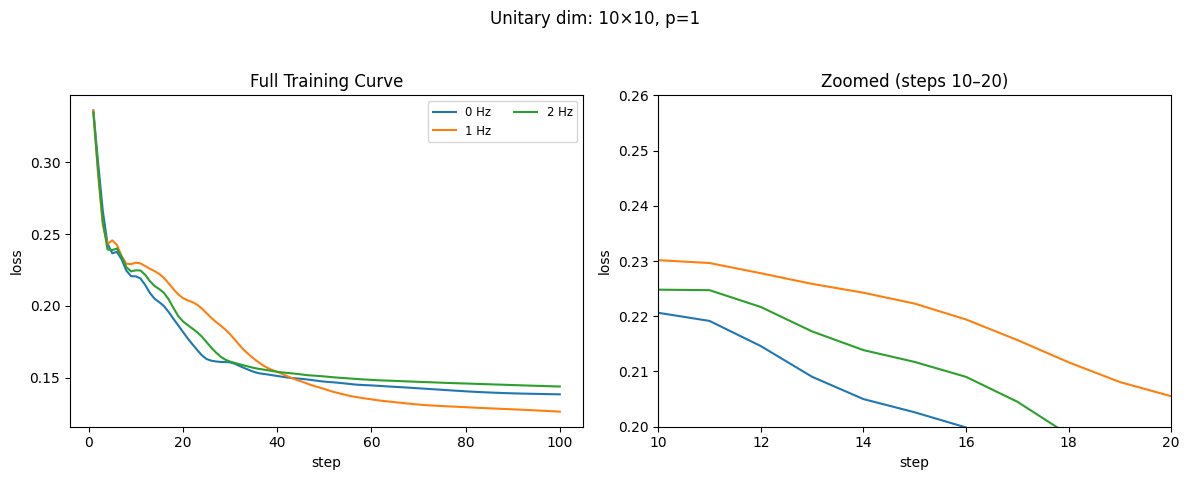

In [34]:
data_folder   = "new2-reup-fix"
# data_folder   = "reup-vary-1p"
min_freq    = 0
max_freq      = 2
x_min = 10
x_max = 20
y_min= 0.2
y_max=0.26
prefix = 'f'
# create two side-by-side plots with independent y-axes
fig, (ax_full, ax_zoom) = g.plt.subplots(1, 2, figsize=(12, 5))

for freq in range(min_freq, max_freq + 1):
    data_name    = f"{prefix}{freq}.npz"
    globals_name = f"{prefix}{freq}g.npz"

    # load
    out      = g.np.load(g.os.path.join(data_folder, data_name))
    steps    = out["loss_mem"][:, 0].astype(int)
    losses   = out["loss_mem"][:, 1].astype(float)

    # plot on both axes
    ax_full.plot(steps, losses, linewidth=1.5, label=f"{freq} Hz")
    ax_zoom.plot(steps, losses, linewidth=1.5, label=f"{freq} Hz")

# format the full-range plot
ax_full.set(
    xlabel="step",
    ylabel="loss",
    title="Full Training Curve"
)

# format the zoomed-in plot with its own y-limits
ax_zoom.set(
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    xlabel="step",
    ylabel="loss",
    title=f"Zoomed (steps {x_min}–{x_max})"
)

# single legend on the full plot
handles, labels = ax_full.get_legend_handles_labels()
ax_full.legend(handles, labels, loc="upper right", ncol=2, fontsize="small")

# overall title
gl = g.np.load(g.os.path.join(data_folder, f"{prefix}{max_freq}g.npz"))
shape = out["carry_0"].shape
fig.suptitle(
    f"Unitary dim: {2*shape[1]}×{2*shape[1]}, p={gl['p_suc_inputs'].item()}"
)

g.plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.plt.show()



In [8]:
log_file = 'data_log'
folder = 'fix-p-suc-vary-p1-d1'
p_suc_list = [1, 0.9, 0.8, 0.5]

for p_suc in p_suc_list:
    test_name    = f"p{p_suc}.npz"
    global_name = f"p{p_suc}g.npz"
    

    g.p_suc_inputs = p_suc
    g.input_config = g.input_config_maker(g.input_positions, g.num_modes_circ, g.p_suc_inputs)

    #  Initialize the phases
    init_phases = circ.initialize_phases(g.depth, 2*g.num_features, )  
    weights_data = g.jnp.ones(shape = [init_phases.shape[0],init_phases.shape[1]])
    # Initialize the carry for Adam.
    # init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data, master_key)
    photon_loss_scale = float(1)
    # compute the very first loss:
    initial_loss, (n0, key) = loss.loss(init_phases, train_set, train_labels, weights_data, photon_loss_scale, g.input_config, g.master_key, g.loss_function, g.aim, g.reupload_freq)
    init_carry = (init_phases, train_set, train_labels, weights_data, photon_loss_scale,
                                                    0.0*init_phases, 0.0*init_phases,
                                                    0.0*weights_data, 0.0*weights_data,
                                                    0.0*photon_loss_scale, 0.0*photon_loss_scale, 
                                                    key, initial_loss)

    carry, loss_mem, update_mem, photon_mem = utils.save_run(log_file, folder, test_name, global_name, init_carry)
    print(p_suc, " done")


[save_run] Saved outputs → fix-p-suc-vary-p1-d1/p1.npz
[save_run] Saved globals → fix-p-suc-vary-p1-d1/p1g.npz
[save_run] Appended entry to data_log
1  done
[save_run] Saved outputs → fix-p-suc-vary-p1-d1/p0.9.npz
[save_run] Saved globals → fix-p-suc-vary-p1-d1/p0.9g.npz
[save_run] Appended entry to data_log
0.9  done
[save_run] Saved outputs → fix-p-suc-vary-p1-d1/p0.8.npz
[save_run] Saved globals → fix-p-suc-vary-p1-d1/p0.8g.npz
[save_run] Appended entry to data_log
0.8  done
[save_run] Saved outputs → fix-p-suc-vary-p1-d1/p0.5.npz
[save_run] Saved globals → fix-p-suc-vary-p1-d1/p0.5g.npz
[save_run] Appended entry to data_log
0.5  done


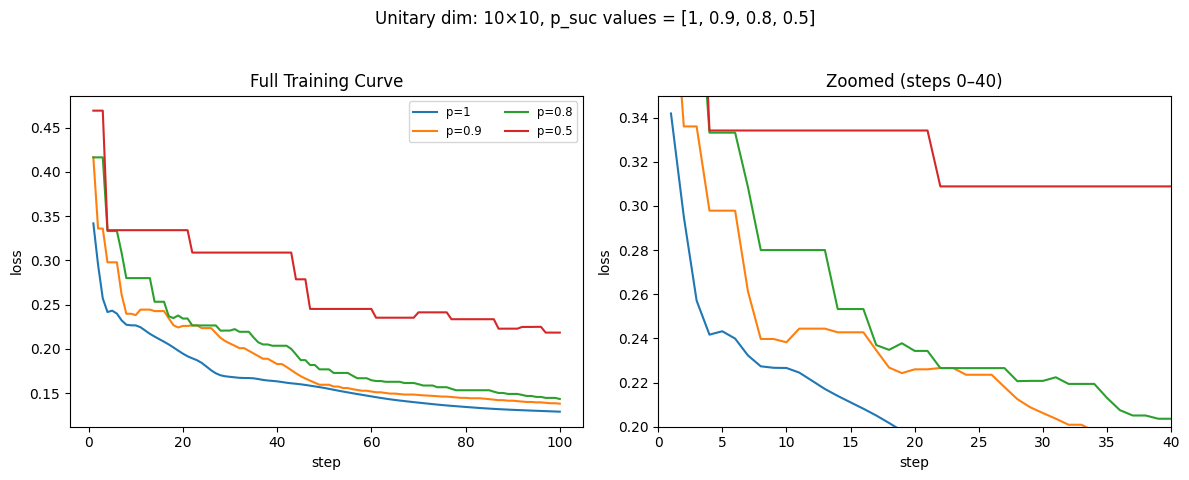

In [9]:
# parameters
log_file    = 'data_log'
folder      = 'fix-p-suc-vary-p1-d1'
p_suc_list  = [1, 0.9, 0.8, 0.5]
x_min, x_max = 0, 40
y_min, y_max = 0.2, 0.35

# create side-by-side plots with independent y-axes
fig, (ax_full, ax_zoom) = g.plt.subplots(1, 2, figsize=(12, 5), sharey=False)

for p_suc in p_suc_list:
    data_name    = f"p{p_suc}.npz"
    globals_name = f"p{p_suc}g.npz"

    # load data
    out      = g.np.load(g.os.path.join(folder, data_name))
    loss_mem = out["loss_mem"]
    steps    = loss_mem[:, 0].astype(int)
    losses   = loss_mem[:, 1].astype(float)

    # plot on both axes
    ax_full.plot(steps, losses, linewidth=1.5, label=f"p={p_suc}")
    ax_zoom.plot(steps, losses, linewidth=1.5, label=f"p={p_suc}")

# format full-range plot
ax_full.set(
    #ylim=(0.38,0.4),
    xlabel="step",
    ylabel="loss",
    title="Full Training Curve"
)

# format zoomed-in plot
ax_zoom.set(
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    xlabel="step",
    ylabel="loss",
    title=f"Zoomed (steps {x_min}–{x_max})"
)

# combined legend on full plot
handles, labels = ax_full.get_legend_handles_labels()
ax_full.legend(handles, labels, loc="upper right", ncol=2, fontsize="small")

# overall title
last_glob = g.np.load(g.os.path.join(folder, f"p{p_suc_list[-1]}g.npz"))
carry_shape = out["carry_0"].shape
fig.suptitle(
    f"Unitary dim: {2*carry_shape[1]}×{2*carry_shape[1]}, "
    f"p_suc values = {p_suc_list}"
)

g.plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.plt.show()

In [12]:
log_file = 'data_log'
folder = 'fix-p-suc-vary-p1-d0'
p_suc_list = [1, 0.9, 0.8, 0.5]

for p_suc in p_suc_list:
    test_name    = f"p{p_suc}.npz"
    global_name = f"p{p_suc}g.npz"
    

    g.p_suc_inputs = p_suc
    g.input_config = g.input_config_maker(g.input_positions, g.num_modes_circ, g.p_suc_inputs)

    #  Initialize the phases
    init_phases = circ.initialize_phases(g.depth, 2*g.num_features, )  
    weights_data = g.jnp.ones(shape = [init_phases.shape[0],init_phases.shape[1]])
    # Initialize the carry for Adam.
    # init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data, master_key)
    photon_loss_scale = float(1)
    # compute the very first loss:
    initial_loss, (n0, key) = loss.loss(init_phases, train_set, train_labels, weights_data, photon_loss_scale, g.input_config, g.master_key, g.loss_function, g.aim, g.reupload_freq)
    init_carry = (init_phases, train_set, train_labels, weights_data, photon_loss_scale,
                                                    0.0*init_phases, 0.0*init_phases,
                                                    0.0*weights_data, 0.0*weights_data,
                                                    0.0*photon_loss_scale, 0.0*photon_loss_scale, 
                                                    key, initial_loss)

    carry, loss_mem, update_mem, photon_mem = utils.save_run(log_file, folder, test_name, global_name, init_carry)
    print(p_suc, " done")

[save_run] Saved outputs → fix-p-suc-vary-p1-d0/p1.npz
[save_run] Saved globals → fix-p-suc-vary-p1-d0/p1g.npz
[save_run] Appended entry to data_log
1  done
[save_run] Saved outputs → fix-p-suc-vary-p1-d0/p0.9.npz
[save_run] Saved globals → fix-p-suc-vary-p1-d0/p0.9g.npz
[save_run] Appended entry to data_log
0.9  done
[save_run] Saved outputs → fix-p-suc-vary-p1-d0/p0.8.npz
[save_run] Saved globals → fix-p-suc-vary-p1-d0/p0.8g.npz
[save_run] Appended entry to data_log
0.8  done
[save_run] Saved outputs → fix-p-suc-vary-p1-d0/p0.5.npz
[save_run] Saved globals → fix-p-suc-vary-p1-d0/p0.5g.npz
[save_run] Appended entry to data_log
0.5  done


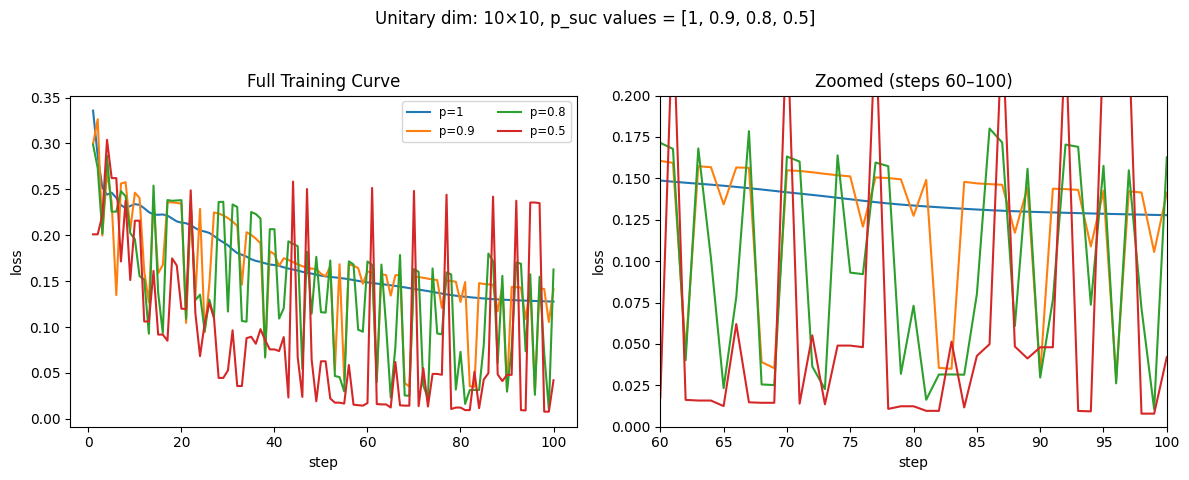

In [13]:
# parameters
log_file    = 'data_log'
folder      = 'fix-p-suc-vary-p1-d0'
p_suc_list  = [1, 0.9, 0.8, 0.5]
x_min, x_max = 60, 100
y_min, y_max = 0, 0.2

# create side-by-side plots with independent y-axes
fig, (ax_full, ax_zoom) = g.plt.subplots(1, 2, figsize=(12, 5), sharey=False)

for p_suc in p_suc_list:
    data_name    = f"p{p_suc}.npz"
    globals_name = f"p{p_suc}g.npz"

    # load data
    out      = g.np.load(g.os.path.join(folder, data_name))
    loss_mem = out["loss_mem"]
    steps    = loss_mem[:, 0].astype(int)
    losses   = loss_mem[:, 1].astype(float)

    # plot on both axes
    ax_full.plot(steps, losses, linewidth=1.5, label=f"p={p_suc}")
    ax_zoom.plot(steps, losses, linewidth=1.5, label=f"p={p_suc}")

# format full-range plot
ax_full.set(
    #ylim=(0.38,0.4),
    xlabel="step",
    ylabel="loss",
    title="Full Training Curve"
)

# format zoomed-in plot
ax_zoom.set(
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    xlabel="step",
    ylabel="loss",
    title=f"Zoomed (steps {x_min}–{x_max})"
)

# combined legend on full plot
handles, labels = ax_full.get_legend_handles_labels()
ax_full.legend(handles, labels, loc="upper right", ncol=2, fontsize="small")

# overall title
last_glob = g.np.load(g.os.path.join(folder, f"p{p_suc_list[-1]}g.npz"))
carry_shape = out["carry_0"].shape
fig.suptitle(
    f"Unitary dim: {2*carry_shape[1]}×{2*carry_shape[1]}, "
    f"p_suc values = {p_suc_list}"
)

g.plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.plt.show()


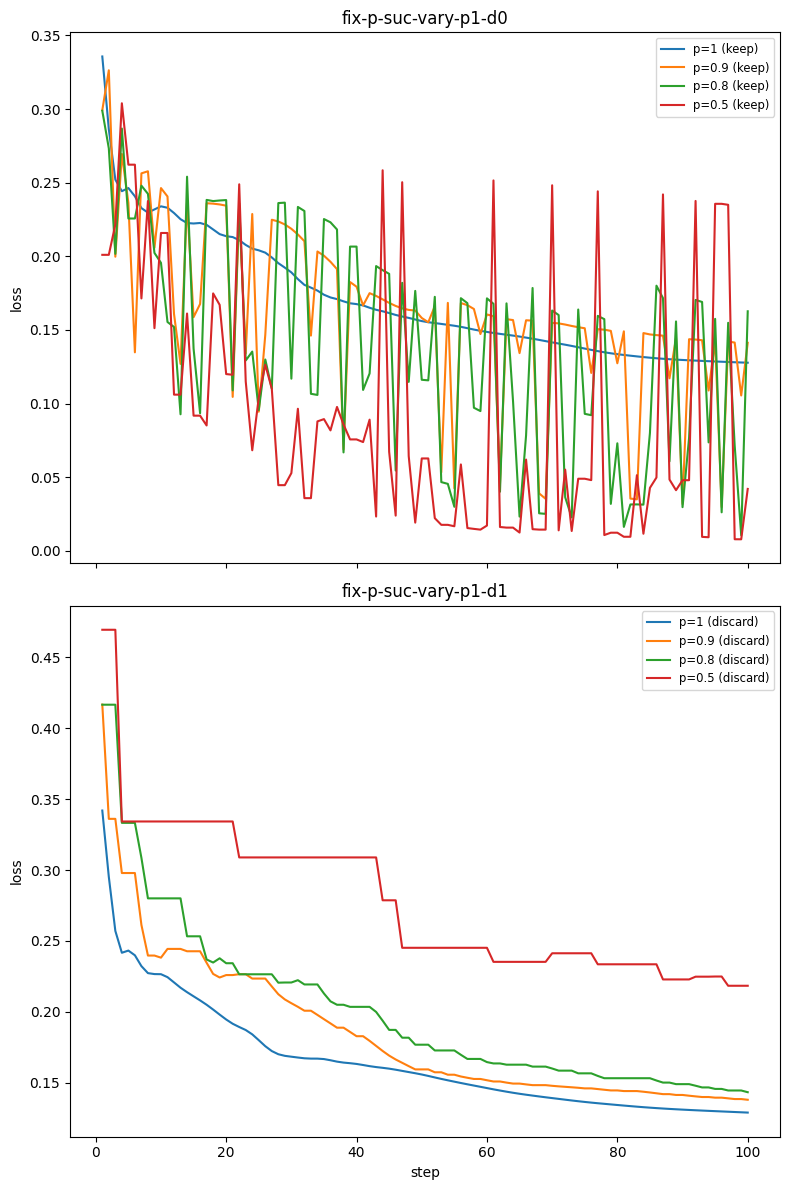

In [14]:
folders     = ["fix-p-suc-vary-p1-d0", "fix-p-suc-vary-p1-d1"]
p_suc_list  = [1, 0.9, 0.8, 0.5]

# create a vertical stack of 3 subplots
fig, axes = g.plt.subplots(nrows=len(folders), ncols=1, figsize=(8, 12), sharex=True)

for ax, folder in zip(axes, folders):
    for p_suc in p_suc_list:
        data_name = f"p{p_suc}.npz"
        out       = g.np.load(g.os.path.join(folder, data_name))
        steps     = out["loss_mem"][:, 0].astype(int)
        losses    = out["loss_mem"][:, 1].astype(float)

        # determine discard/keep from folder name
        if "d1" in folder:
            d_label = "discard"
        elif "d0" in folder:
            d_label = "keep"
        else:
            d_label = ""

        label = f"p={p_suc}" + (f" ({d_label})" if d_label else "")
        ax.plot(steps, losses, linewidth=1.5, label=label)

    ax.set_ylabel("loss")
    ax.set_title(folder)
    ax.legend(loc="upper right", fontsize="small")

# only the bottom plot gets the x-axis label
axes[-1].set_xlabel("step")

g.plt.tight_layout()
g.plt.show()

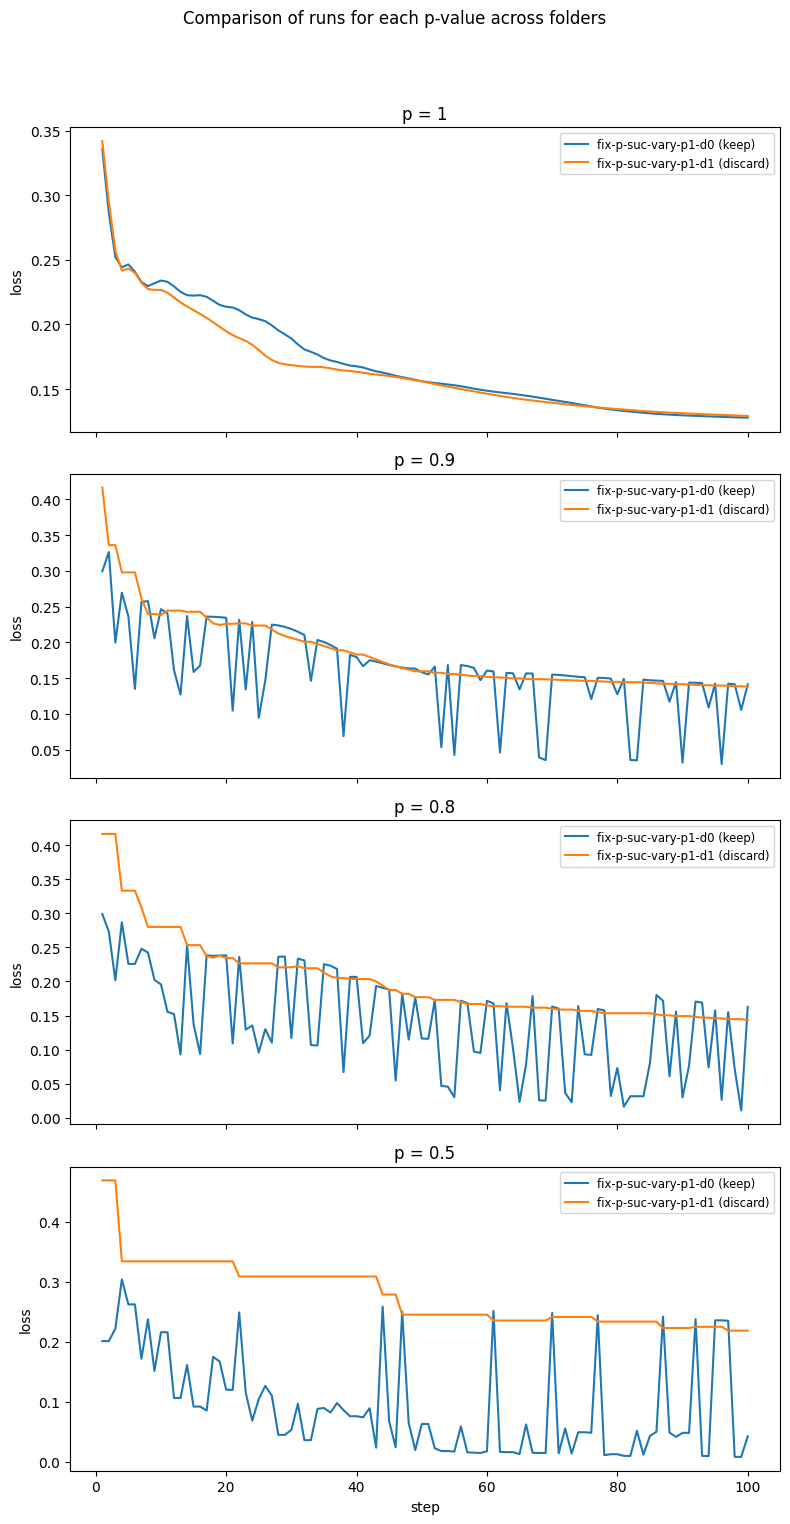

In [15]:
fig, axes = g.plt.subplots(
    nrows=len(p_suc_list),
    ncols=1,
    figsize=(8, 4 * len(p_suc_list)),
    sharex=True
)

for ax, p_suc in zip(axes, p_suc_list):
    for folder in folders:
        data_name = f"p{p_suc}.npz"
        out = g.np.load(g.os.path.join(folder, data_name))
        steps = out["loss_mem"][:, 0].astype(int)
        losses = out["loss_mem"][:, 1].astype(float)

        # Determine keep/discard status from folder name
        status = "discard" if "d1" in folder else "keep"
        label = f"{folder} ({status})"

        ax.plot(steps, losses, linewidth=1.5, label=label)

    ax.set_ylabel("loss")
    ax.set_title(f"p = {p_suc}")
    ax.legend(loc="upper right", fontsize="small")

# Label the shared x-axis on the bottom subplot
axes[-1].set_xlabel("step")

fig.suptitle("Comparison of runs for each p-value across folders")
g.plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.plt.show()

In [18]:
log_file = 'data_log'
folder = 'fix-position-vary-p1'
position_list = [[0],[1],[2],[3],[4],[5]]

for p_suc in position_list:
    test_name    = f"p{str(p_suc[0])}.npz"
    global_name = f"p{str(p_suc[0])}g.npz"
    

    g.input_positions = p_suc
    g.input_config = g.input_config_maker(g.input_positions, g.num_modes_circ, g.p_suc_inputs)

    #  Initialize the phases
    init_phases = circ.initialize_phases(g.depth, 2*g.num_features, )  
    weights_data = g.jnp.ones(shape = [init_phases.shape[0],init_phases.shape[1]])
    # Initialize the carry for Adam.
    # init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data, master_key)
    photon_loss_scale = float(1)
    # compute the very first loss:
    initial_loss, (n0, key) = loss.loss(init_phases, train_set, train_labels, weights_data, photon_loss_scale, g.input_config, g.master_key, g.loss_function, g.aim, g.reupload_freq)
    init_carry = (init_phases, train_set, train_labels, weights_data, photon_loss_scale,
                                                    0.0*init_phases, 0.0*init_phases,
                                                    0.0*weights_data, 0.0*weights_data,
                                                    0.0*photon_loss_scale, 0.0*photon_loss_scale, 
                                                    key, initial_loss)

    carry, loss_mem, update_mem, photon_mem = utils.save_run(log_file, folder, test_name, global_name, init_carry)
    print(p_suc, " done")


[save_run] Saved outputs → fix-position-vary-p1/p0.npz
[save_run] Saved globals → fix-position-vary-p1/p0g.npz
[save_run] Appended entry to data_log
[0]  done
[save_run] Saved outputs → fix-position-vary-p1/p1.npz
[save_run] Saved globals → fix-position-vary-p1/p1g.npz
[save_run] Appended entry to data_log
[1]  done
[save_run] Saved outputs → fix-position-vary-p1/p2.npz
[save_run] Saved globals → fix-position-vary-p1/p2g.npz
[save_run] Appended entry to data_log
[2]  done
[save_run] Saved outputs → fix-position-vary-p1/p3.npz
[save_run] Saved globals → fix-position-vary-p1/p3g.npz
[save_run] Appended entry to data_log
[3]  done
[save_run] Saved outputs → fix-position-vary-p1/p4.npz
[save_run] Saved globals → fix-position-vary-p1/p4g.npz
[save_run] Appended entry to data_log
[4]  done
[save_run] Saved outputs → fix-position-vary-p1/p5.npz
[save_run] Saved globals → fix-position-vary-p1/p5g.npz
[save_run] Appended entry to data_log
[5]  done


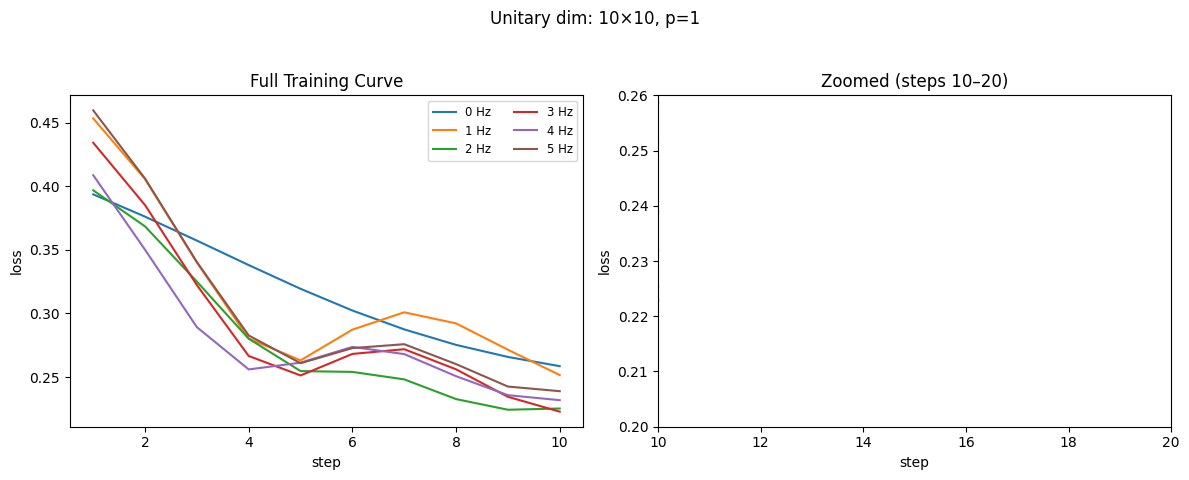

In [20]:
data_folder   = "fix-position-vary-p1"
# data_folder   = "reup-vary-1p"
min_freq    = 0
max_freq      = 5
x_min = 10
x_max = 20
y_min= 0.2
y_max=0.26
prefix = 'p'
# create two side-by-side plots with independent y-axes
fig, (ax_full, ax_zoom) = g.plt.subplots(1, 2, figsize=(12, 5))

for freq in range(min_freq, max_freq + 1):
    data_name    = f"{prefix}{freq}.npz"
    globals_name = f"{prefix}{freq}g.npz"

    # load
    out      = g.np.load(g.os.path.join(data_folder, data_name))
    steps    = out["loss_mem"][:, 0].astype(int)
    losses   = out["loss_mem"][:, 1].astype(float)

    # plot on both axes
    ax_full.plot(steps, losses, linewidth=1.5, label=f"{freq} Hz")
    ax_zoom.plot(steps, losses, linewidth=1.5, label=f"{freq} Hz")

# format the full-range plot
ax_full.set(
    xlabel="step",
    ylabel="loss",
    title="Full Training Curve"
)

# format the zoomed-in plot with its own y-limits
ax_zoom.set(
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    xlabel="step",
    ylabel="loss",
    title=f"Zoomed (steps {x_min}–{x_max})"
)

# single legend on the full plot
handles, labels = ax_full.get_legend_handles_labels()
ax_full.legend(handles, labels, loc="upper right", ncol=2, fontsize="small")

# overall title
gl = g.np.load(g.os.path.join(data_folder, f"{prefix}{max_freq}g.npz"))
shape = out["carry_0"].shape
fig.suptitle(
    f"Unitary dim: {2*shape[1]}×{2*shape[1]}, p={gl['p_suc_inputs'].item()}"
)

g.plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.plt.show()

In [36]:
log_file = 'data_log'
folder = 'photon-vary'
position_list = [[0], '2', '3']

for p_suc in position_list:
    test_name    = f"p{str(p_suc[0])}.npz"
    global_name = f"p{str(p_suc[0])}g.npz"
    

    g.input_positions = p_suc
    g.input_config = g.input_config_maker(g.input_positions, g.num_modes_circ, g.p_suc_inputs)

    #  Initialize the phases
    init_phases = circ.initialize_phases(g.depth, 2*g.num_features, )  
    weights_data = g.jnp.ones(shape = [init_phases.shape[0],init_phases.shape[1]])
    # Initialize the carry for Adam.
    # init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data, master_key)
    photon_loss_scale = float(1)
    # compute the very first loss:
    initial_loss, (n0, key) = loss.loss(init_phases, train_set, train_labels, weights_data, photon_loss_scale, g.input_config, g.master_key, g.loss_function, g.aim, g.reupload_freq)
    init_carry = (init_phases, train_set, train_labels, weights_data, photon_loss_scale,
                                                    0.0*init_phases, 0.0*init_phases,
                                                    0.0*weights_data, 0.0*weights_data,
                                                    0.0*photon_loss_scale, 0.0*photon_loss_scale, 
                                                    key, initial_loss)

    carry, loss_mem, update_mem, photon_mem = utils.save_run(log_file, folder, test_name, global_name, init_carry)
    print(p_suc, " done")

[save_run] Saved outputs → photon-vary/p0.npz
[save_run] Saved globals → photon-vary/p0g.npz
[save_run] Appended entry to data_log
[0]  done
[save_run] Saved outputs → photon-vary/p2.npz
[save_run] Saved globals → photon-vary/p2g.npz
[save_run] Appended entry to data_log
2  done
[save_run] Saved outputs → photon-vary/p3.npz
[save_run] Saved globals → photon-vary/p3g.npz
[save_run] Appended entry to data_log
3  done


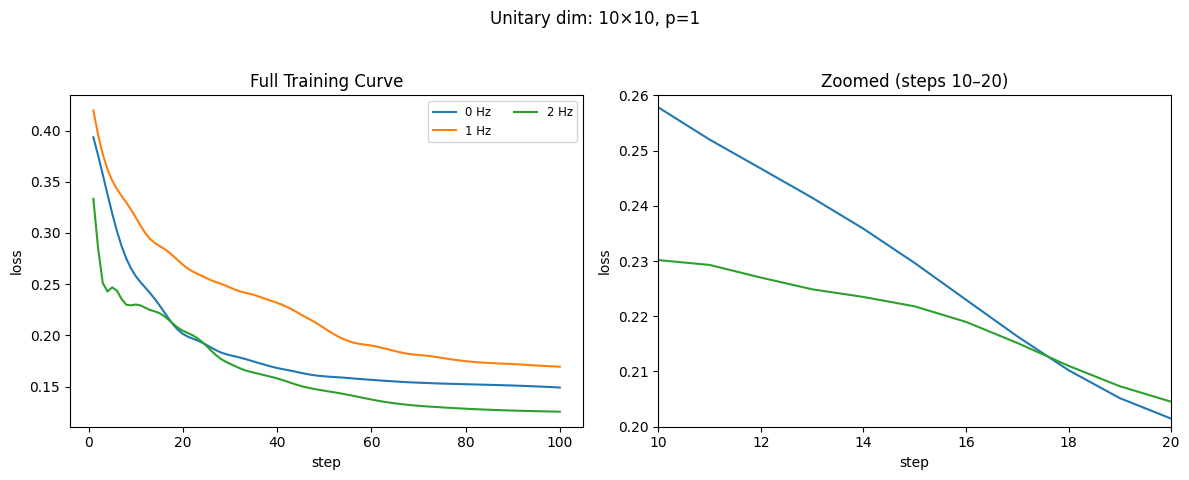

In [41]:
data_folder   = "photon-vary"
# data_folder   = "reup-vary-1p"
min_freq    = 0
max_freq      = 2
x_min = 10
x_max = 20
y_min= 0.2
y_max=0.26
prefix = 'p'
# create two side-by-side plots with independent y-axes
fig, (ax_full, ax_zoom) = g.plt.subplots(1, 2, figsize=(12, 5))

for freq in range(min_freq, max_freq + 1):
    data_name    = f"{prefix}{freq}.npz"
    globals_name = f"{prefix}{freq}g.npz"

    # load
    out      = g.np.load(g.os.path.join(data_folder, data_name))
    steps    = out["loss_mem"][:, 0].astype(int)
    losses   = out["loss_mem"][:, 1].astype(float)

    # plot on both axes
    ax_full.plot(steps, losses, linewidth=1.5, label=f"{freq} Hz")
    ax_zoom.plot(steps, losses, linewidth=1.5, label=f"{freq} Hz")

# format the full-range plot
ax_full.set(
    xlabel="step",
    ylabel="loss",
    title="Full Training Curve"
)

# format the zoomed-in plot with its own y-limits
ax_zoom.set(
    xlim=(x_min, x_max),
    ylim=(y_min, y_max),
    xlabel="step",
    ylabel="loss",
    title=f"Zoomed (steps {x_min}–{x_max})"
)

# single legend on the full plot
handles, labels = ax_full.get_legend_handles_labels()
ax_full.legend(handles, labels, loc="upper right", ncol=2, fontsize="small")

# overall title
gl = g.np.load(g.os.path.join(data_folder, f"{prefix}{max_freq}g.npz"))
shape = out["carry_0"].shape
fig.suptitle(
    f"Unitary dim: {2*shape[1]}×{2*shape[1]}, p={gl['p_suc_inputs'].item()}"
)

g.plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.plt.show()

Photon= 1, steps=5, time=0.28 min
Photon= 3, steps=5, time=0.26 min
Photon= 5, steps=5, time=0.24 min


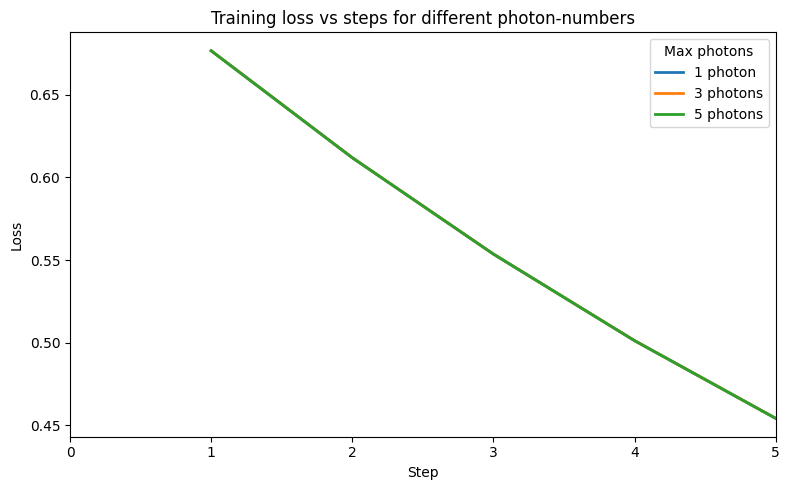

In [12]:
# list of photon‐numbers to sweep
photon_numbers = [1, 3, 5]

# container for (steps, losses) tuples
results = {}

for n in photon_numbers:
    # --- update your configuration per‐run ---
    g.input_positions = str(n)
    g.max_photons     = n

    # initialize phases & weights
    init_phases = circ.initialize_phases(g.depth, 2*g.num_features)
    weights_data = g.jnp.ones(shape = [init_phases.shape[0],init_phases.shape[1]])
    # initial loss / key
    initial_loss, (n0, key) = loss.loss(
        init_phases,
        train_set,
        train_labels,
        weights_data,
        float(1),               # photon_loss_scale
        g.input_config,
        g.master_key,
        g.loss_function,
        g.aim
    )

    # build the Adam‐carry
    init_carry = (
        init_phases,
        train_set,
        train_labels,
        weights_data,
        1.0,                    # photon_loss_scale
        0.0*init_phases,
        0.0*init_phases,
        0.0*weights_data,
        0.0*weights_data,
        0.0,                    # m scale for photon_loss
        0.0,                    # v scale for photon_loss
        key,
        initial_loss
    )

    # run training
    t0 = g.time.time()
    carry, loss_mem, *_ = g.jax.block_until_ready(train.train(init_carry))
    t1 = g.time.time()
    print(f"Photon={n:>2}, steps={g.num_steps}, time={(t1-t0)/60:.2f} min")

    # extract steps & loss
    steps  = g.np.array(loss_mem[:, 0], dtype=int)
    losses = g.np.array(loss_mem[:, 1], dtype=float)
    results[n] = (steps, losses)

# plot all curves
fig, ax = g.plt.subplots(figsize=(8,5))
for n, (steps, losses) in results.items():
    ax.plot(steps, losses, linewidth=2, label=f"{n} photon{'s' if n>1 else ''}")

ax.set_xlim(0, g.num_steps)
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
ax.set_title("Training loss vs steps for different photon‑numbers")
ax.legend(title="Max photons")
g.plt.tight_layout()
g.plt.show()


## Training Loss - Multi Depth

In [14]:
depth_list = [8, 10, 12] # depth = number of layers

Training with depth = 8


ValueError: not enough values to unpack (expected 10, got 8)

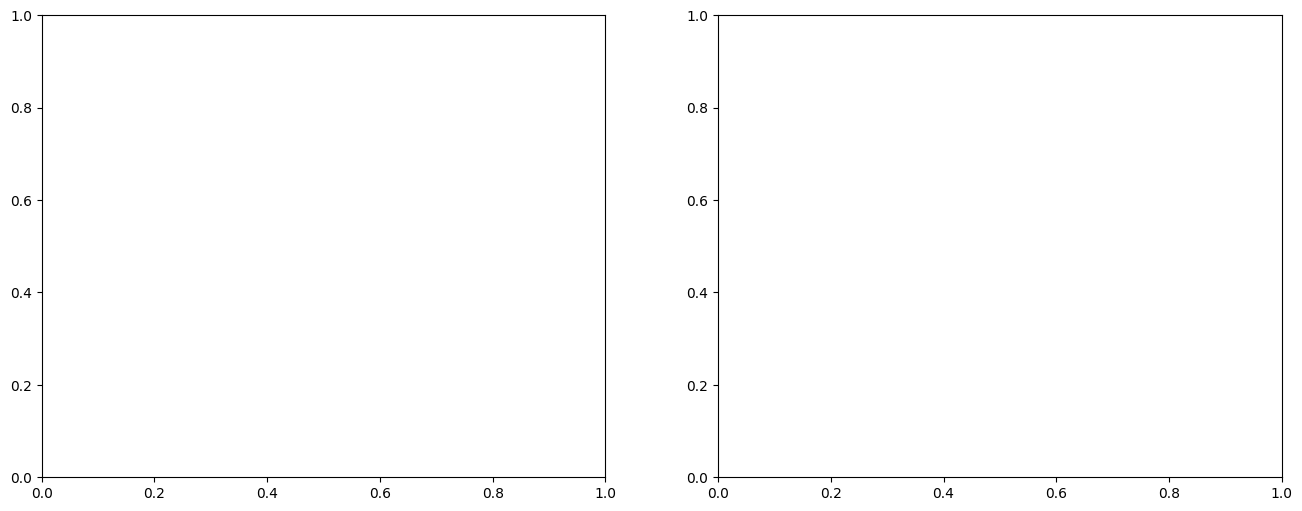

In [15]:
results = []; fig, (ax1, ax2) = g.plt.subplots(1, 2, figsize=(16, 6))
for depth in depth_list:
    print(f"Training with depth = {depth}"); 
    #initialize parameters
    a = g.time.time()
    init_phases = circ.initialize_phases(depth, 2*g.num_features)
    weights_data = g.jnp.ones(shape=[init_phases.shape[0], init_phases.shape[1]])
    init = ( init_phases, train_set, train_labels, weights_data,0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data)
    # Run the training.
    b = g.time.time()
    carry, loss_mem = g.jax.block_until_ready(train.train)(init)
    # Loss Before/After on train set + Loss on test set
    c = g.time.time()
    trained_phases, trained_weights = carry[0], carry[3]
    init_loss, train_loss, test_loss = float(loss.loss(init_phases, train_set, train_labels, weights_data)), float(loss.loss(trained_phases, train_set, train_labels, trained_weights)), float(loss.loss(trained_phases, test_set, test_labels, trained_weights))
    d = g.time.time()
    #plot learning curve for given depth
    ax1.plot(g.np.array(loss_mem[:,0]), g.np.array(loss_mem[:,1]), label=f"Depth {depth}")
    #timing calcs
    init_time_min, train_time_min, loss_time_min, total_time_min = (b-a)/60, (c-b)/60, (d-c)/60, (d-a)/60
    #append results
    results.append({"depth": depth, "train_loss_before": init_loss, "train_loss_after": train_loss, "test_loss_after": test_loss, 
                    "init_time_min": init_time_min, "loss_time_min": loss_time_min, "train_time_min": train_time_min,"total_time_min": total_time_min})
# Finalize left subplot
ax1.set_xlim(0, g.num_steps)
ax1.set_xlabel("step"); ax1.set_ylabel("loss")
ax1.set_title(f"Learning Curves (Unitary dim: {2*init_phases.shape[1]}×{2*init_phases.shape[1]})")
ax1.legend()
# Prepare data for right subplot (final losses vs depth)
depth_vals, train_vals, test_vals = [r["depth"] for r in results], [r["train_loss_after"] for r in results], [r["test_loss_after"] for r in results]
# Plot final losses vs depth
ax2.plot(depth_vals, train_vals, 'o-', label="Train loss"); ax2.plot(depth_vals, test_vals,  's-', label="Test loss")
ax2.set_xlabel("Depth"); ax2.set_ylabel("Final loss")
ax2.set_title(f"Final Loss vs Depth (Unitary dim: {2*init_phases.shape[1]}×{2*init_phases.shape[1]})")
ax2.grid(True)
ax2.legend()
g.plt.tight_layout()
g.plt.show()
# Create and print the results table
results_df = g.pd.DataFrame(results)
print(results_df.to_string(index=False, float_format="%.4F"))

## Training Loss - Multi Feature

In [90]:
feature_dims = [3,4,5]
depth = 10  # Set your desired constant depth here

Training with 3 features (depth=10)
Training with 4 features (depth=10)
Training with 5 features (depth=10)


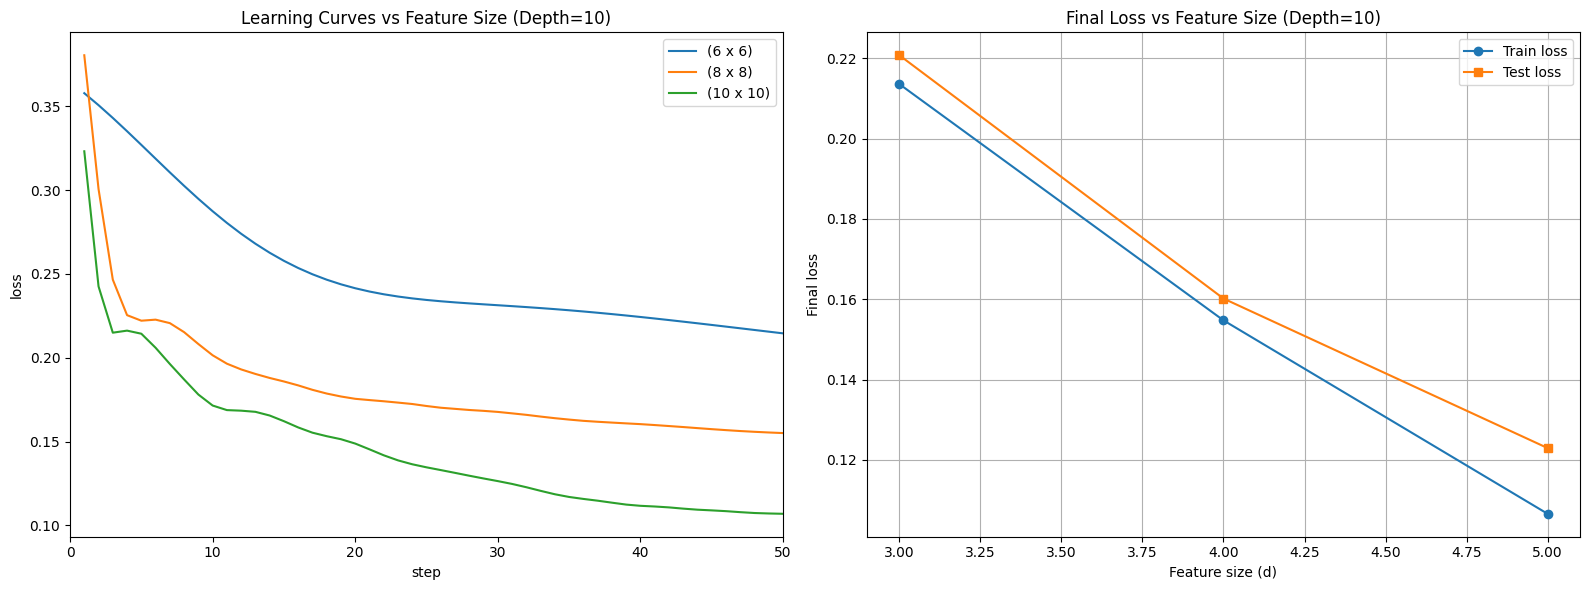

 features  train_loss_before  train_loss_after  test_loss_after  load_data_time_min  init_time_min  loss_time_min  train_time_min  total_time_min
        3             0.3579            0.2136           0.2207              0.0016         0.0004         0.3992          0.0006          0.4018
        4             0.3805            0.1547           0.1602              0.0013         0.0007         0.6971          0.0008          0.7000
        5             0.3232            0.1066           0.1230              0.0014         0.0004         1.2625          0.0008          1.2652


In [91]:
results = []
fig, (ax1, ax2) = g.plt.subplots(1, 2, figsize=(16, 6))
for f_dims in feature_dims:
    print(f"Training with {f_dims} features (depth={depth})")
    # making sure to change num_features in globals file as all other files refernce from there
    g.num_features = f_dims
    # Load, split and rescale data for the current feature dimension
    a = g.time.time()
    split_data = globals.load_and_split_data(f_dims)
    train_set, train_labels, test_set, test_labels = split_data
    train_set = pre_p.rescale_data(train_set, min_val = -(g.np.pi)/2, max_val = (g.np.pi/2))
    test_set = pre_p.rescale_data(test_set, min_val = -(g.np.pi)/2, max_val = (g.np.pi/2))
    # Initialize the phases and weights
    b = g.time.time()
    init_phases = circ.initialize_phases(depth, 2*f_dims)
    weights_data = g.jnp.ones(shape=[init_phases.shape[0], init_phases.shape[1]])
    init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data)
    # training
    c = g.time.time()
    carry, loss_mem = g.jax.block_until_ready(train.train)(init)
    # Loss Before/After on train set + Loss on test set
    d = g.time.time()
    trained_phases, trained_weights  = carry[0], carry[3]
    init_loss, train_loss, test_loss = float(loss.loss(init_phases, train_set, train_labels, weights_data)), float(loss.loss(trained_phases, train_set, train_labels, trained_weights)), float(loss.loss(trained_phases, test_set, test_labels, trained_weights))
    # time calcs
    e = g.time.time()
    load_data_time_min, init_time_min, train_time_min, loss_time_min, total_time_min = (b-a)/60, (c-b)/60, (d-c)/60, (e-d)/60, (e-a)/60
    #plot data
    ax1.plot(g.np.array(loss_mem[:,0]), g.np.array(loss_mem[:,1]), label=f"({2*f_dims} x {2*f_dims})")
    #store results
    results.append({"features": f_dims, "train_loss_before": init_loss, "train_loss_after": train_loss, "test_loss_after": test_loss, 
                    "load_data_time_min": load_data_time_min, "init_time_min": init_time_min, "loss_time_min": loss_time_min, "train_time_min": train_time_min,"total_time_min": total_time_min})
# finalize left subplot
ax1.set_xlim(0, g.num_steps); ax1.set_xlabel("step"); ax1.set_ylabel("loss")
ax1.set_title(f"Learning Curves vs Feature Size (Depth={depth})"); ax1.legend()
# prepare and plot final losses vs feature size
f_vals = [r["features"] for r in results]; tr = [r["train_loss_after"] for r in results]; te = [r["test_loss_after"] for r in results]
ax2.plot(f_vals, tr, 'o-', label="Train loss"); ax2.plot(f_vals, te, 's-', label="Test loss")
ax2.set_xlabel("Feature size (d)"); ax2.set_ylabel("Final loss")
ax2.set_title(f"Final Loss vs Feature Size (Depth={depth})"); ax2.grid(True); ax2.legend()
g.plt.tight_layout(); g.plt.show()
# print results table
results_df = g.pd.DataFrame(results); print(results_df.to_string(index=False, float_format="%.4F"))